<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_o23/blob/main/codigo/modelos_preentrenados/intro.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Inferencia ResNet18

##     Configuración inicial y carga del modelo pre-entrenado:

In [11]:
# Importamos las bibliotecas necesarias
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

El modelo de ResNet18 se encuentra en la libreria de torchvision

In [13]:
# Cargamos el modelo pre-entrenado ResNet18 y lo ponemos en modo de evaluación
model = models.resnet18()
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Cargamos las etiquetas de ImageNet para interpretar las predicciones
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
labels = requests.get(LABELS_URL).json()

Veamos que labels o etiquetas tiene el ImageNet

In [15]:
labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

##     Pre-procesamiento de la imagen:

Tenemos que hacer que la imagenes que entren a nuestro modelo sean compatibles con el (por ejemplo en el numero de pixeles y canales). Para eso debemos transformarlas usando la funcion de `transform` de pytorch. En este caso cortamos y centramos las imagenes

In [16]:
# Definimos una transformación para la imagen que coincide con el pre-procesamiento usado durante el entrenamiento de ResNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## Imagen

Descarga una imagen de la web (usando el URL) para probar la imagen

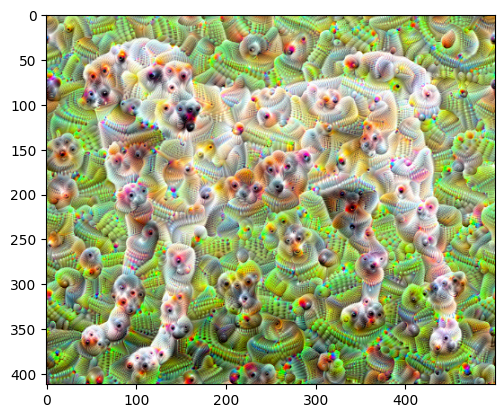

In [17]:
# Descargamos una imagen de ejemplo
img_url = 'https://www.tensorflow.org/tutorials/generative/images/dogception.png'
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# Visualicemos la imagen
imgplot = plt.imshow(img)
plt.show()

In [18]:
# Aplicamos la transformación
tensor_img = transform(img).unsqueeze(0)

In [19]:
# Realizamos una predicción con el modelo
with torch.no_grad():
    outputs = model(tensor_img.to(device))
    _, predicted = outputs.max(1)
    class_id = predicted.item()
    class_label = labels[str(class_id)][1]

print(f"Predicción: {class_label}")


Predicción: aircraft_carrier


# Fine-Tune ResNet18 para CIFAR10

## 1. Eleccion de Modelo

Utilizaremos ResNet18 para prediccion de CIFAR10

In [20]:
import torch
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Cargmaos el modelo de ResNet18 de nuevo

In [21]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.5MB/s]


## 2. Adaptar la Arquitectura


Modifiquemos la ultima capa para que corresponda con el CIFAR10

In [22]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 tiene 10 clases
model = model.to(device)

Creemos las transformaciones que debemos aplicar a las imagenes para que sean compatibles con Resnet18

In [23]:
# Transformaciones para los conjuntos de datos
transform = transforms.Compose([
    transforms.Resize(224),  # Cambiamos el tamaño de las imágenes de CIFAR-10 para adaptarlas a ResNet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Entrenamiento

### Carga de Datos

In [24]:
# Cargar datasets
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:02<00:00, 64955687.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


### Definir funciones de entrenamiento

Definamos una funcion de entrenamiento.

In [25]:
def train_and_evaluate(model, optimizer, criterion, num_epochs=5):
    model = model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            corrects_train += torch.sum(preds == labels.data)

        epoch_train_acc = corrects_train.double() / len(train_loader.dataset)
        train_accuracies.append(epoch_train_acc)
        train_losses.append(running_loss / len(train_loader.dataset))

        model.eval()
        running_loss = 0.0
        corrects_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                corrects_val += torch.sum(preds == labels.data)

        epoch_val_acc = corrects_val.double() / len(val_loader.dataset)
        val_accuracies.append(epoch_val_acc)
        val_losses.append(running_loss / len(val_loader.dataset))


    return train_losses, val_losses, train_accuracies, val_accuracies

In [26]:
def test_model(model, criterion):
    model = model.to(device)
    model.eval()
    running_loss = 0.0
    corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    accuracy = corrects.double() / len(test_loader.dataset)
    return test_loss, accuracy

Funcion de visualizacion

In [43]:
# Función para graficar
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy, title):
    train_accuracies = [c.item() for c in train_accuracies]
    val_accuracies = [c.item() for c in val_accuracies]
    test_accuracy = test_accuracy.item()


    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r^-', label='Validation Loss')
    plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')
    plt.title(title + ' - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r^-', label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
    plt.title(title + ' - Accuracy')
    plt.legend()

    plt.show()

### Estrategia Entrenando todas las Capas

In [28]:
def full_resnet_training(lr=.001):
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()

model1, optimizer1 = full_resnet_training()
train_losses1, val_losses1, train_accuracies1, val_accuracies1 = train_and_evaluate(model1,
                                                optimizer1, criterion, num_epochs=5)
test_loss1, test_accuracy1 = test_model(model1, criterion)

In [40]:
test_accuracy1

tensor(0.5805, device='cuda:0', dtype=torch.float64)

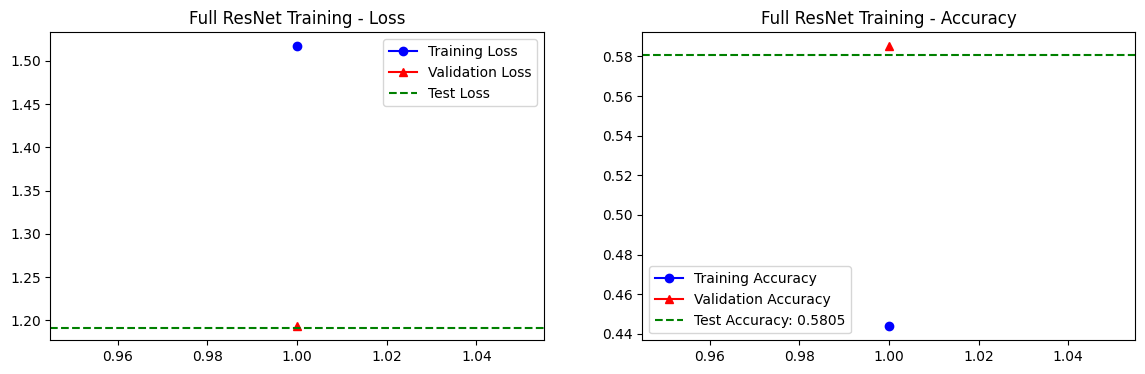

In [44]:
plot_metrics(train_losses1, val_losses1, train_accuracies1, val_accuracies1, test_loss1, test_accuracy1, "Full ResNet Training")

### Estrategia de congelar Capas y agregar una pequena red al final

In [45]:
def freeze_resnet_add_head(lr=.001):
    model = models.resnet18()
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 10)
    )
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    return model, optimizer

In [ ]:

model2, optimizer2 = freeze_resnet_add_head()
train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train_and_evaluate(model2, optimizer2, criterion,
                                                                                    num_epochs=5)
test_loss2, test_accuracy2 = test_model(model2, criterion)

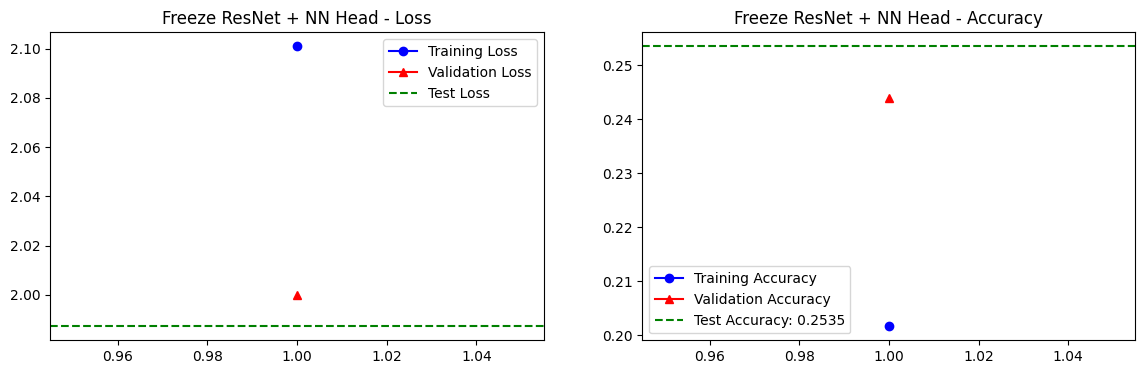

In [48]:
plot_metrics(train_losses2, val_losses2, train_accuracies2, val_accuracies2, test_loss2, test_accuracy2, "Freeze ResNet + NN Head")


In [ ]:

def freeze_early_layers_add_head(lr=0.001):
    model = models.resnet18(pretrained=True)  # Asumiendo que quieres un modelo preentrenado

    # Congelar las primeras capas: todo excepto el último bloque
    for name, param in model.named_parameters():
        if 'layer4' not in name:
            param.requires_grad = False

    # Nueva "cabeza" para el modelo
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 10)  # 10 clases, por ejemplo
    )

    # Usamos el optimizador sólo para los parámetros que requieren gradiente (la "cabeza" y el último bloque)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    return model, optimizer

In [ ]:


model3, optimizer3 = freeze_early_layers_add_head()
train_losses3, val_losses3, train_accuracies3, val_accuracies3 = train_and_evaluate(model3, optimizer3, criterion,
                                                                                    num_epochs=1)
test_loss3, test_accuracy3 = test_model(model3, criterion)